<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/SDUEBA_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dependencies
import numpy as np
import pandas as pd
from collections import Counter
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder

#Only for importing data
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
#Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""


vector_space_dimention = 30
n_clusters = 20
max_depth = 5
test_size = 0.2
mixed_threashold = 0.7


In [3]:
"""
Tady je treba dopsat kod k vytvoreni features_df, targets_df
Nevim jak to udelat obecne pro ruzne datasety a ruzne metody nacitani dat :(
"""

nursery = fetch_ucirepo(id=76)

features_raw = pd.DataFrame(data=nursery.data.features)
target_df = pd.DataFrame(data=nursery.data.targets)
target_df['class'] = target_df['class'].replace({'priority': 'recommend',
                                                 'not_recom': 'not_recommend',
                                                 'very_recom': 'recommend',
                                                 'spec_prior': 'recommend'})

In [4]:
#Data augemntation sentence creation
features_df = pd.DataFrame()
for column in features_raw.columns:
    split_columns = column.split("_")
    jointed_columns = ' '.join(split_columns)
    features_df[column] = features_raw[column].apply(lambda x: f"{jointed_columns} is {x}")

sentences = []
for i in range(len(features_df)):
    sentence = []
    for word in features_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

[['parents is usual', 'has nurs is proper', 'form is complete', 'children is 1', 'housing is convenient', 'finance is convenient', 'social is nonprob', 'health is recommended'], ['parents is usual', 'has nurs is proper', 'form is complete', 'children is 1', 'housing is convenient', 'finance is convenient', 'social is nonprob', 'health is priority'], ['parents is usual', 'has nurs is proper', 'form is complete', 'children is 1', 'housing is convenient', 'finance is convenient', 'social is nonprob', 'health is not_recom'], ['parents is usual', 'has nurs is proper', 'form is complete', 'children is 1', 'housing is convenient', 'finance is convenient', 'social is slightly_prob', 'health is recommended'], ['parents is usual', 'has nurs is proper', 'form is complete', 'children is 1', 'housing is convenient', 'finance is convenient', 'social is slightly_prob', 'health is priority'], ['parents is usual', 'has nurs is proper', 'form is complete', 'children is 1', 'housing is convenient', 'fina

In [5]:
#Word2Vec training and clustering
def sentence_embedding(sentence, model):
    word_embeddings = []
    for word in sentence:
        word_embeddings.append(model.wv[word])
    return np.mean(word_embeddings, axis=0)

model = Word2Vec(sentences, min_count=1, vector_size=vector_space_dimention, window=5)
embeddings = np.array([sentence_embedding(sentence, model) for sentence in sentences])
labels_aglomerative_average = AgglomerativeClustering(n_clusters= n_clusters, metric = 'cosine', linkage='average').fit_predict(embeddings)

In [6]:
#Decission tree training
features_classify = features_raw.assign(cluster = labels_aglomerative_average)

encoder = OneHotEncoder()
X = features_classify.drop(columns=['cluster'])
X_encoded = encoder.fit_transform(X)
y = features_classify['cluster']
X_df = pd.DataFrame(X, columns=encoder.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=test_size, random_state=73, stratify=y)

clf = DecisionTreeClassifier(max_depth=max_depth, random_state=73)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.7550154320987654
              precision    recall  f1-score   support

           0       0.67      0.93      0.78       254
           1       0.90      1.00      0.95       158
           2       0.62      0.85      0.72       123
           3       0.82      0.89      0.85       274
           4       0.86      0.97      0.91       240
           5       0.89      0.69      0.77       235
           6       0.55      0.62      0.59        77
           7       0.88      0.87      0.88       111
           8       0.00      0.00      0.00        72
           9       0.85      0.62      0.72       235
          10       0.00      0.00      0.00        46
          11       0.76      0.50      0.60        50
          12       0.62      0.79      0.70        71
          13       0.00      0.00      0.00        46
          14       0.00      0.00      0.00        34
          15       0.65      0.89      0.75       122
          16       0.62      0.91      0.74       23

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
def classify_clusters(data_frame, target_df, mixed_threshold, cluster_labels, frequencies=False):

    cluster_to_class_counts = {}
    for i, label in enumerate(cluster_labels):
        cluster_to_class_counts.setdefault(label, {})
        class_label = target_df['class'][i]
        cluster_to_class_counts[label][class_label] = cluster_to_class_counts[label].get(class_label, 0) + 1

    cluster_classifications = {}
    cluster_frequencies = {}
    for cluster, class_counts in cluster_to_class_counts.items():
        total_count = sum(class_counts.values())
        dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
        relative_frequency = dominant_count / total_count

        if relative_frequency >= mixed_threshold:
            cluster_classifications[cluster] = dominant_class
        else:
            cluster_classifications[cluster] = 'mixed'

        cluster_frequencies[cluster] = total_count

    if frequencies:
        return dict(sorted(cluster_classifications.items())), dict(sorted(cluster_frequencies.items()))
    else:
        return dict(sorted(cluster_classifications.items()))

classify_clusters(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average, frequencies = True)

({0: 'recommend',
  1: 'mixed',
  2: 'mixed',
  3: 'mixed',
  4: 'mixed',
  5: 'mixed',
  6: 'mixed',
  7: 'mixed',
  8: 'mixed',
  9: 'mixed',
  10: 'mixed',
  11: 'mixed',
  12: 'mixed',
  13: 'mixed',
  14: 'mixed',
  15: 'mixed',
  16: 'mixed',
  17: 'recommend',
  18: 'recommend',
  19: 'recommend'},
 {0: 1272,
  1: 792,
  2: 612,
  3: 1368,
  4: 1200,
  5: 1176,
  6: 384,
  7: 555,
  8: 360,
  9: 1176,
  10: 228,
  11: 252,
  12: 354,
  13: 228,
  14: 168,
  15: 612,
  16: 1152,
  17: 192,
  18: 369,
  19: 510})

In [11]:
def extract_rules(tree, feature_names, class_names, cluster_classifications, node=0, depth=0, rule=[], rules_list=None, unextractable_clusters=None):

    if rules_list is None:
        rules_list = []
    if unextractable_clusters is None:
        unextractable_clusters = []

    left_child = tree.tree_.children_left[node]
    right_child = tree.tree_.children_right[node]
    threshold = tree.tree_.threshold[node]
    feature = tree.tree_.feature[node]
    value = tree.tree_.value[node]

    if left_child == -1 and right_child == -1:
        class_label = class_names[value.argmax()]
        rules_list.append((class_label, " AND ".join(rule)))
        return rules_list, unextractable_clusters

    if left_child != -1:
        left_rule = rule + [f"{feature_names[feature]} <= {threshold:.2f}"]
        rules_list, unextractable_clusters = extract_rules(tree, feature_names, class_names, cluster_classifications, left_child, depth + 1, left_rule, rules_list, unextractable_clusters)

    if right_child != -1:
        right_rule = rule + [f"{feature_names[feature]} > {threshold:.2f}"]
        rules_list, unextractable_clusters = extract_rules(tree, feature_names, class_names, cluster_classifications, right_child, depth + 1, right_rule, rules_list, unextractable_clusters)

    if depth == 0:
        sorted_rules = sorted(rules_list, key=lambda x: x[0])
        print("Rules for subgroups:")
        extracted_clusters = set()

        for class_label, rule_text in sorted_rules:
            extracted_clusters.add(class_label)
            print(f"Rule for subgroup '{class_label}' ({cluster_classifications[class_label]}): {rule_text}")

        for cluster, classification in cluster_classifications.items():
            if cluster not in extracted_clusters:
                unextractable_clusters.append(cluster)

    return rules_list, unextractable_clusters

rules, unextractable_clusters = extract_rules(clf, list(X_df.columns), list(set(features_classify['cluster'])), cluster_classifications=classify_clusters(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average))
print(f"Unextractable clusters: {unextractable_clusters}")

Rules for subgroups:
Rule for subgroup '0' (recommend): parents_usual <= 0.50 AND parents_pretentious <= 0.50 AND has_nurs_proper <= 0.50 AND has_nurs_very_crit <= 0.50 AND housing_critical <= 0.50
Rule for subgroup '1' (mixed): parents_usual <= 0.50 AND parents_pretentious > 0.50 AND has_nurs_proper > 0.50 AND form_complete <= 0.50
Rule for subgroup '1' (mixed): parents_usual <= 0.50 AND parents_pretentious > 0.50 AND has_nurs_proper > 0.50 AND form_complete > 0.50 AND health_priority <= 0.50
Rule for subgroup '1' (mixed): parents_usual <= 0.50 AND parents_pretentious > 0.50 AND has_nurs_proper > 0.50 AND form_complete > 0.50 AND health_priority > 0.50
Rule for subgroup '2' (mixed): parents_usual <= 0.50 AND parents_pretentious > 0.50 AND has_nurs_proper <= 0.50 AND has_nurs_very_crit <= 0.50 AND housing_critical > 0.50
Rule for subgroup '3' (mixed): parents_usual > 0.50 AND has_nurs_proper <= 0.50 AND has_nurs_very_crit <= 0.50 AND has_nurs_critical <= 0.50 AND form_complete <= 0.50


In [9]:
#Cluster metrics
def calculate_support(data_frame, target_df, mixed_threshold, cluster_labels):

    classifications, frequencies = classify_clusters(data_frame, target_df, mixed_threshold, cluster_labels, frequencies=True)

    total_targets = len(cluster_labels)

    support = sum(freq for cluster, freq in frequencies.items() if cluster not in unextractable_clusters)

    support_percentage = (support / total_targets) * 100
    return support_percentage

support = calculate_support(features_df, target_df, mixed_threashold, cluster_labels=labels_aglomerative_average)
print(f"Overall support of describable subgroups is {support:.2f}%") #Subgroups can be undescribable if they are too small and decission tree cant find the rules for characterization
#Entropy, serendipity TBD - dont know how to do it at the moment

Overall support of describable subgroups is 90.93%


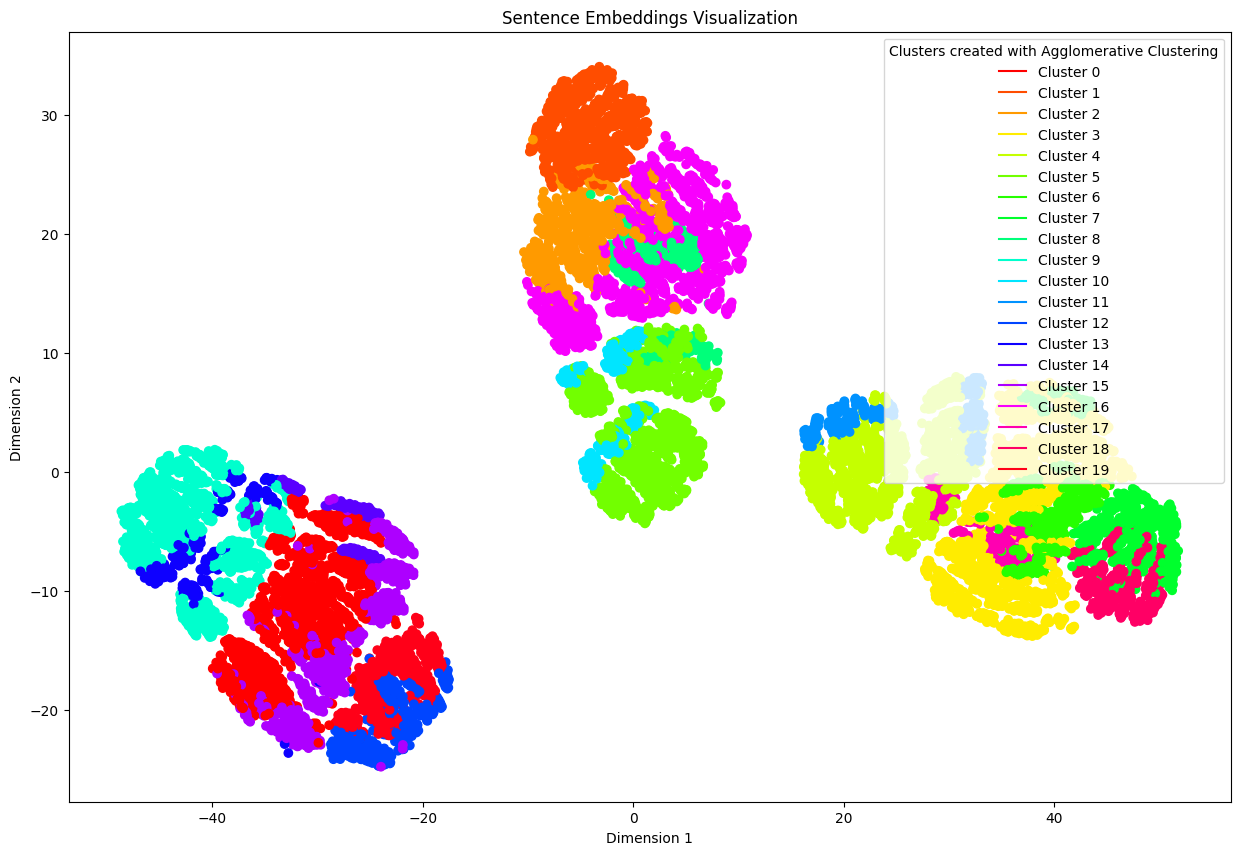

In [10]:
#Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    if cluster_labels is not None and target_labels is None:
        n_clusters = len(set(cluster_labels))
        colors = cmap(np.linspace(0, 1, n_clusters))
        handles = [plt.Line2D([], [], color=color) for color in colors]
        labels = [f"Cluster {i}" for i in range(n_clusters)]
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

        plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")

    elif target_labels is not None and cluster_labels is None:

        edible_color = 'green'
        poisonous_color = 'red'

        colors = [edible_color if label == 'edible' else poisonous_color for label in target_labels]

        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
        handles = [plt.Line2D([], [], color=edible_color, label='Edible'), plt.Line2D([], [], color=poisonous_color, label='Poisonous')]

        labels = ['Edible', 'Poisonous']

        plt.legend(handles=handles, labels=labels, title="Classes", loc="upper right")


    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(sentences)), cmap=cmap)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels_aglomerative_average, clustering_method='Agglomerative Clustering')